# Creating HAS-model embeddings for entities in a KG
The purpose of these will be for assessing entities' similarities to one another. This measure of similarity between entities will in turn be used to assess the distinctiveness of labels that have previously been created and filtered for this KG.

## Pre-requisite steps to run this notebook
1. You need to run the 1_candidate_label_creation notebook before this notebook.
2. gensim is a dependency. You can install it with `pip install --upgrade gensim`, or if you want to use Anaconda, `conda install -c conda-forge gensim`

In [30]:
import os
import random
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from collections import Counter
from h_path_walks import get_h_walks_from_kgtk_item_file
import seaborn as sns

## parameters

**Embedding model parameters**  
*directed*: If true, treat graph as directed when performing H-feature walks. Otherwise undirected.  
*num_H_walks*: Number of random walks to start at each node with the H-feature walk method  
*num_A_walks*: Number of random walks to start at each node with the A-feature walk method  
*num_S_walks*: Number of random walks to start at each node with the S-feature walk method  
*walk_length*: Length of random walk started at each node  
*representation_size*: Number of latent dimensions to learn from each node  
*window_size*: Window size of skipgram model  
*workers*: Number of parallel processes  

**File/Directory parameters**  
*item_file*: File path for the file that contains entity to entity relationships (e.g. wikibase-item).  
*label_file*: File path for the file that contains wikidata labels.  
*time_file*: file path for the file that contains entity to time-type values  
*quantity_file*: file path for the file that contains entity to quantity-type values  
*work_dir*: same work_dir that you specified in the label creation notebook. We'll look for files created by that notebook here. Files created by this notebook will also be saved here.  
*store_dir*: Path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

In [31]:
# Embedding model params
directed = False
num_H_walks = 10
num_A_walks = 10
num_S_walks = 10
walk_length = 10
representation_size = 64
window_size = 5
workers = 32

# File/Directory params
# item_file = "../../Q44/data/Q44.part.wikibase-item.tsv"
# label_file = "../../Q44/data/Q44.label.en.tsv"
# time_file = "../../Q44/data/Q44.part.time.tsv"
# quantity_file = "../../Q44/data/Q44.part.quantity.tsv"
# work_dir = "../../Q44/profiler_work"
# store_dir = "../../Q44"

item_file = "../../Q154/data/claims.wikibase-item.tsv.gz"
label_file = "../../Q154/data/labels.en.tsv.gz"
time_file = "../../Q154/data/claims.time.tsv.gz"
quantity_file = "../../Q154/data/claims.quantity.tsv.gz"
work_dir = "../../Q154/profiler_work"
store_dir = "../../Q154"

### Process parameters and set up variables / file names

In [32]:
# Ensure paths are absolute
item_file = os.path.abspath(item_file)
label_file = os.path.abspath(label_file)
time_file = os.path.abspath(time_file)
quantity_file = os.path.abspath(quantity_file)
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
    
# Create directories
if not os.path.exists(work_dir):
    os.makedirs(work_dir)
output_dir = "{}/HAS_embeddings".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Setting up environment variables 
os.environ['ITEM_FILE'] = item_file
os.environ['LABEL_FILE'] = label_file
os.environ['TIME_FILE'] = time_file
os.environ['QUANTITY_FILE'] = quantity_file
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['LABEL_CREATION'] = "{}/label_creation".format(work_dir)
os.environ['OUT'] = output_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

Start with empty corpus of walks. We'll add to this in the following steps.

In [33]:
walks = []

### 1. H-Paths
These random walks are intended to detect similarity due to homophily. Random walks are performed in a DFS manner.   For more detail of implementation / analysis of this individual feature, take a look at the H_walks_analysis notebook.

In [34]:
%%time
if num_H_walks > 0:
    h_walks = get_h_walks_from_kgtk_item_file(item_file, directed, walk_length, num_H_walks)
    walks.extend(h_walks)

CPU times: user 52.2 s, sys: 8.22 s, total: 1min
Wall time: 1min 2s


### 2. A-Paths
#### 2.1 Create simple embeddings for entities based on the value of their attributes
**Things to keep in mind here:**  
- We are only using numeric valued attributes here. The paper uses string valued attributes as well.
- We are not accounting for the possibility that an entity could have two values for a single property. This is something we need to do, though we do not need to do it yet for this example with the Q44 data.
- We are not sure how they dealt with entities that are missing a value for some attrbiute. Ideas:
    - use average value from other entities that have the attribute
    - only compare attributes that both entities have
    - if there is an attribute that only one of the two entities being compared has a value for, then distance in that dimension is max possible distance.. i.e. since we will normalize the embeddings, difference in this dimension can be 1. However, we are certain this is not what they do because they look for neighbors within a hypercube, not within a hypersphere. If we look for neighbors within a hypercube, then this option would lead to random walks having only entities that have the same set of attributes. While this is an approach we could take, it could be implemented in a much more straightforward and efficient way.
    - Do the above option and compute distance using the L2 norm (hypersphere). This would be different from what the paper did but might give better results? But also it would be less efficient, and we know the method in the paper went with a hypercube to make it computationally feasible on large graphs.

In [35]:
# Either move this up to the top in parameter section, or do this for all types in the graph
type_to_profile = "Q44"
os.environ["TYPE"] = type_to_profile

First dealing with time attributes

In [36]:
!kgtk query -i $LABEL_CREATION/entity_attribute_labels_time.year.tsv --graph-cache $STORE \
-o $OUT/${TYPE}_entity_attribute_vals_time.year.tsv \
--match 'labels: (type:`'"$TYPE"'`)-[l {entity:e, label:p, property_label:p_lab}]->(val)' \
--return 'distinct e as entity, p as prop, p_lab as prop_label, val as value' \
--order-by 'e, p, val'

In [37]:
!head $OUT/${TYPE}_entity_attribute_vals_time.year.tsv | column -t -s $'\t'

entity     prop  prop_label                                    value
Q1026242   P571  'inception'@en                                1780
Q1026242   P576  'dissolved, abolished or demolished date'@en  1995
Q1035257   P571  'inception'@en                                1985
Q128237    P571  'inception'@en                                2000
Q12877510  P571  'inception'@en                                1996
Q1295815   P571  'inception'@en                                1969
Q1378288   P571  'inception'@en                                2004
Q1378288   P577  'publication date'@en                         2004
Q1474909   P571  'inception'@en                                1933


Next, quantity attributes. These may have units, and we want units to contribute to defining the attribute, so the prop column below will consist of \<property\>_\<si_units\>_\<wd_units\>

In [38]:
!kgtk query -i $LABEL_CREATION/entity_attribute_labels_quantity.tsv --graph-cache $STORE \
-o $OUT/${TYPE}_entity_attribute_vals_quantity.tsv \
--match 'labels: (type:`'"$TYPE"'`)-[l {entity:e, label:p, property_label:p_lab, si_units:si, wd_units:wd}]->(val)' \
--return 'distinct e as entity, printf("%s_%s_%s", p, si, wd) as prop, p_lab as prop_label, val as value' \
--order-by 'e, p, val'

In [39]:
!head -15 $OUT/${TYPE}_entity_attribute_vals_quantity.tsv | column -t -s $'\t'

entity     prop             prop_label                  value
Q1017471   P2665__Q2080811  'alcohol by volume'@en      12
Q12877510  P2226__          'market capitalization'@en  3896025.7
Q1984359   P2665__Q2080811  'alcohol by volume'@en      7.5
Q21286736  P2665__Q2080811  'alcohol by volume'@en      4.9
Q2175711   P2665__Q2080811  'alcohol by volume'@en      8
Q2175711   P6088__Q2000486  'beer bitterness'@en        40
Q615718    P2665__Q2080811  'alcohol by volume'@en      8.4
Q63993001  P2665__Q11229    'alcohol by volume'@en      5.2
Q6811722   P2665__Q2080811  'alcohol by volume'@en      4.6
Q6811722   P2665__Q2080811  'alcohol by volume'@en      4.9
Q77311740  P2665__Q2080811  'alcohol by volume'@en      5
Q78640580  P2234__Q11582    'volume as quantity'@en     0.5
Q78640580  P2665__Q2080811  'alcohol by volume'@en      5.0
Q81413031  P2665__Q2080811  'alcohol by volume'@en      6


Load <entity, attribute, value> triples to Python, create embeddings from there.  
Embeddings will have $|A_t|$ dimensions where $A_t$ is the set of distinct attributes that entities of type $t$ have.

**Note, here we have a choice about how to fill in dimensions for an entity that doesn't have a value for all attributes.** E.g. average value for that dimension, or don't fill it in and later only compare dimensions that both entities have ...

In [40]:
attributes_df = pd.read_csv("{}/{}_entity_attribute_vals_time.year.tsv".format(output_dir, type_to_profile), delimiter = '\t').fillna("")
attributes_df = attributes_df.append(pd.read_csv("{}/{}_entity_attribute_vals_quantity.tsv".format(output_dir, type_to_profile), delimiter = '\t').fillna(""))

attributes = attributes_df.prop.unique()
entities = attributes_df.entity.unique()
attr_to_idx = {attributes[ix] : ix for ix in range(len(attributes))}
ent_to_idx = {entities[ix] : ix for ix in range(len(entities))}
embeddings = np.full((len(entities),len(attributes)), np.nan)

for ent, attr, val in zip(attributes_df['entity'], attributes_df['prop'], attributes_df['value']):
    embeddings[ent_to_idx[ent], attr_to_idx[attr]] = val

# normalize each dimension
embeddings -= np.nanmin(embeddings,0)
embeddings /= [m if m != 0 else 1 for m in np.nanmax(embeddings,0)]

# NOTE - filling nan's with the average value in that dimension.
# There are other options we could go with... see "things to note"-
# list under section header above
embeddings = np.nan_to_num(embeddings, nan=np.nanmean(embeddings, 0))

#### 2.2 Find the neighbors for each entity that are similar enough to hop to during a random walk.

**notes**  
some code here might be able to be optimized. Authors' code first sorts values in each dimension and binary searches for neighbors in range... this would also require choosing a value for $r$ - a parameter that controls size of the hypercube defining neighbors that are close enough to jump to next. Paper mentions you could adjust $r$ to aim for having number of neighbors in hypercube = average degree in original KG... This does not seem like it would be trivial to automate, and I am thinking we want to automate this. For now, just using simpler pythonic code and finding fixed number of closest neighbors.

From looking at their code, it appears as if they don't do any adjusting of $r$... I think they just choose $r = 1 / \#entities$. We could try this out to see how this works out. However for now, still just using a fixed number of closest neighbors approach.

Also, if we want to change how we deal with missing attribute values to only compare dimensions that both entities being compared have, we'd need to change that here.

In [41]:
# Get the closest k neighbors for each entity, where "closeness"
# is measured by maximum absolute difference in any dimension.
# This can be thought of as finding the smallest hypercube that is
# centered on an entity and contains k other entities within it.
# Params:
#     entities   - array of entities
#     embeddings - array where each row corresponds to the entity at the same index in the entities array,
#                  and each column is a numeric value corresponding to one dimension of the embeddings
#     k          - number of closest neighbors to find 
# Returns: a dictionary of {entity : array of neighbors}
def get_k_neighs(entities, embeddings, k):
    # NOTE - using a fixed number of closest neighbors. This approach may involve more computation,
    # so will need to keep this in mind when scaling up.
    entity_to_neighs = {}

    for i in range(len(entities)):
        max_diffs = np.max(np.abs(embeddings - embeddings[i]), 1)
        max_diffs[i] = np.inf # avoid including entity in its own list of neighbors
        entity_to_neighs[entities[i]] = entities[np.argpartition(max_diffs, k - 1)[:k]]
        
    return entity_to_neighs

In [42]:
# TODO make k a notebook parameter
entity_to_neighs = get_k_neighs(entities, embeddings, 2)
#display(entity_to_neighs)

#### 2.3 Perform the random walks and add to the set that will be used to learn the HAS embeddings

In [43]:
# Performs num_walks random walks at each node in the graph
# i.e. if there are 10 nodes in the gaph and num_walks=10, then we'll do 10*10 = 100 random walks.
# Returns a list of walks
def perform_walks(entity_to_neighs, walk_length=10, num_walks=10):
    start_ents = np.repeat(list(entity_to_neighs.keys()), num_walks)
    # pre-allocate walks array with initial values of ""
    walks = np.full((len(start_ents),walk_length), "", dtype='<U9')
    
    walks[:,0] = start_ents
    cur_length = 1
    while cur_length < walk_length:
        cur_ents = walks[:,cur_length - 1]
        # if we've previously hit a dead end, then we could have "" as a 
        # current entity value. In this case, we want to continue filling in "".
        neighbors = [np.array([""]) if e == "" else entity_to_neighs[e] for e in cur_ents]
        # if there are no neighbors for some entity 
        # we'll make the next entity we visit = ""
        neighbors = [np.array([-1]) if len(arr) < 1 else arr for arr in neighbors]
        next_ents = [np.random.choice(arr) for arr in neighbors]
        walks[:,cur_length] = next_ents
        cur_length += 1
    # trim ""s from any walks that reached a dead end
    walks = [list(arr[arr != ""]) for arr in walks]
    return walks

In [44]:
if num_A_walks > 0:
    A_walks = perform_walks(entity_to_neighs, walk_length, num_A_walks)
    walks.extend(A_walks)

### 3. S-Paths
#### 3.1 Create simple embeddings for entities based on the types of their neighbors

In [45]:
!kgtk query -i $ITEM_FILE -i $LABEL_CREATION/type_mapping.tsv --graph-cache $STORE \
-o $OUT/${TYPE}_entity_neighbor_types.tsv \
--match '`'"$ITEM_FILE"'`: (e1)-[]->(e2), type: (e1)-[]->(t1:`'"$TYPE"'`), type: (e2)-[]->(t2)' \
--return 'distinct e1 as entity, t2 as neighbor_type, count(e2) as count' \
--order-by 'e1, t2'

In [46]:
!head $OUT/${TYPE}_entity_neighbor_types.tsv | column -t -s $'\t'

entity    neighbor_type  count
Q1017471  Q1250464       2
Q1017471  Q131734        1
Q1017471  Q185441        2
Q1017471  Q20181813      2
Q1017471  Q3624078       2
Q1017471  Q43702         2
Q1017471  Q4830453       1
Q1017471  Q6256          2
Q1026242  Q123480        1


Load <entity, attribute, value> triples to Python, create embeddings from there.  
Embeddings will have $|\tau|$ dimensions where $\tau$ is the set of distinct types amongst entities that share an edge with entities of type $t$.

In [47]:
types_df = pd.read_csv("{}/{}_entity_neighbor_types.tsv".format(output_dir, type_to_profile), delimiter = '\t').fillna("")

neigh_types = types_df.neighbor_type.unique()
entities = types_df.entity.unique()
type_to_idx = {neigh_types[ix] : ix for ix in range(len(neigh_types))}
ent_to_idx = {entities[ix] : ix for ix in range(len(entities))}
embeddings = np.zeros((len(entities),len(neigh_types)))

for ent, neigh_type, count in zip(types_df['entity'], types_df['neighbor_type'], types_df['count']):
    embeddings[ent_to_idx[ent], type_to_idx[neigh_type]] = count

# normalize each dimension
embeddings -= np.min(embeddings,0)
embeddings /= [m if m != 0 else 1 for m in np.max(embeddings,0)]

#### 3.2 Find the neighbors for each entity that are similar enough to hop to during a random walk.

In [48]:
# TODO make k a notebook parameter
entity_to_neighs = get_k_neighs(entities, embeddings, 2)
#display(entity_to_neighs)

#### 3.3 Perform the random walks and add to the set that will be used to learn the HAS embeddings

In [49]:
if num_S_walks > 0:
    S_walks = perform_walks(entity_to_neighs, walk_length, num_S_walks)
    walks.extend(S_walks)

### 4. Use Skip-Gram model on the combined set of random walks to learn representations for the entities
Code is currently using the walks created by the undirected graph representation

In [50]:
%%time
model = Word2Vec(walks, size=representation_size, window=window_size, min_count=0, sg=1, hs=1,
                 workers=workers)
model.wv.save("{}/entity_embeddings.kv".format(output_dir))

CPU times: user 6min 13s, sys: 1.62 s, total: 6min 14s
Wall time: 1min 49s


Now we have embeddings for the entities. Here is what Beer looks like:

In [51]:
model.wv["Q44"]

array([ 0.24860492,  0.55687   , -0.01668484,  0.2778652 , -0.13967165,
       -0.7800577 , -0.11382981, -0.13143396,  0.21649022,  0.4571778 ,
        0.361956  ,  0.35887778, -0.58352596, -0.5087976 , -0.12649997,
        0.04303338, -0.8501673 ,  0.5391694 ,  0.5010428 , -0.67736924,
        0.5458317 ,  0.80067736,  0.30261326,  0.23967452, -0.08302388,
       -1.1534282 , -0.15567851, -0.4189477 ,  0.03637625,  0.35952404,
       -0.1493749 ,  0.0888382 , -0.18846495, -0.18188548,  0.05093786,
       -0.30467513,  0.6201615 , -0.6319366 ,  0.579771  ,  0.3395211 ,
        0.24202222,  0.78021324, -0.18230076,  0.7681821 , -0.70423084,
        0.7445575 , -0.1854396 ,  0.23818007, -0.782007  , -0.3608098 ,
        0.28452086, -0.12915976, -0.01998339,  0.2823707 ,  0.31864822,
       -0.5572132 , -0.28617162,  0.44049576, -0.61297905, -0.40536663,
       -0.06624195,  0.02898413,  0.3082091 ,  0.12257467], dtype=float32)

### Evaluate the embeddings
We want similar entities to have more similar embeddings. For the purpose of profiling entities of a desired type, we are specifically interested in similar entities *within a type* having more similar embeddings. I.e. if we look at the embeddings of the various beers we have, do the ones with more similar embeddings have more in common? We'll investigate using cosine similarity.

Let's compare entities of different types. We would expect a sovereign state and a beer to be less similar than two sovereign states.

In [52]:
print("Vergina Weiss and Cape Verde: {:.2f}".format(model.wv.similarity('Q93559285','Q1011')))
print("Ireland and United Kingdom: {:.2f}".format(model.wv.similarity('Q27','Q145')))

Vergina Weiss and Cape Verde: 0.26
Ireland and United Kingdom: 0.79


Now let's compare various things that are more directly related to beer

In [53]:
print("beer and alcoholic beverage: {:.2f}".format(model.wv.similarity('Q44','Q154')))
print("beer and Macedonian Thrace Brewery (instance of both beer and brewery): {:.2f}".format(model.wv.similarity('Q44','Q12877510')))
print("beer and Vergina Alcohol Free (instance of beer): {:.2f}".format(model.wv.similarity('Q44','Q97412285')))
print("beer and Vergina Weiss (instance of beer): {:.2f}".format(model.wv.similarity('Q44','Q93559285')))
print("Vergina Alcohol Free and Vergina Weiss: {:.2f}".format(model.wv.similarity('Q97412285','Q93559285')))

beer and alcoholic beverage: 0.40
beer and Macedonian Thrace Brewery (instance of both beer and brewery): 0.54
beer and Vergina Alcohol Free (instance of beer): 0.62
beer and Vergina Weiss (instance of beer): 0.59
Vergina Alcohol Free and Vergina Weiss: 0.93


Finally, we can look at how similar some beers are to eachother ...  
**what's the best way to do this?... look at what the most similar entity is for some examples... or hand-pick some beers to compare (e.g. different kinds of beers, ABVs, brands, country)**

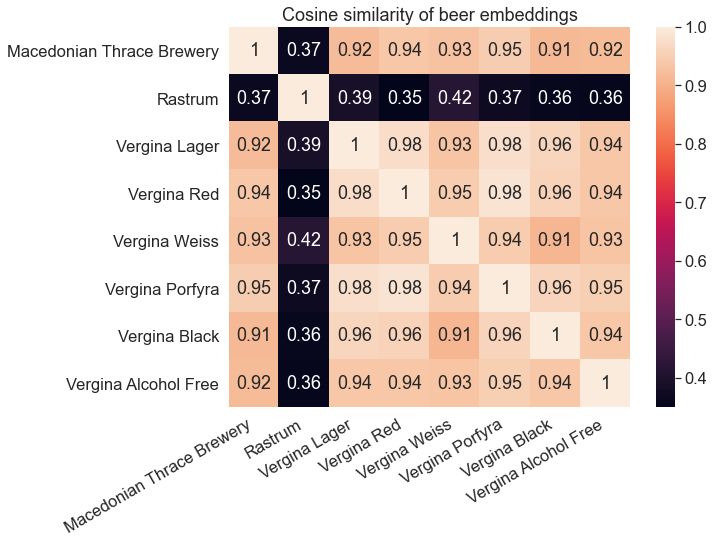

In [54]:
beer_vecs = model.wv['Q12877510', 'Q61976614', 'Q93552342', 'Q93557205', 'Q93559285', 'Q93558270', 'Q93560567', 'Q97412285']
similarity_mat = [model.wv.cosine_similarities(beer, beer_vecs) for beer in beer_vecs]
mask = np.zeros_like(similarity_mat)
mask[np.triu_indices_from(mask)] = True
labels = ['Macedonian Thrace Brewery', 'Rastrum', 'Vergina Lager', 'Vergina Red', 'Vergina Weiss', 'Vergina Porfyra', 'Vergina Black', 'Vergina Alcohol Free']
# Could mask to only show the lower triangle, but I think this is actually easier to read without the mask
fig, ax = plt.subplots(figsize=(9,7))
sns.set(font_scale=1.5)
sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Cosine similarity of beer embeddings")
plt.show()

The beer called 'Rastrum' seems to be an outlier. Searching for it online gives few results related to beer. Looking at similarities without this beer so we can more easily see how the others compare

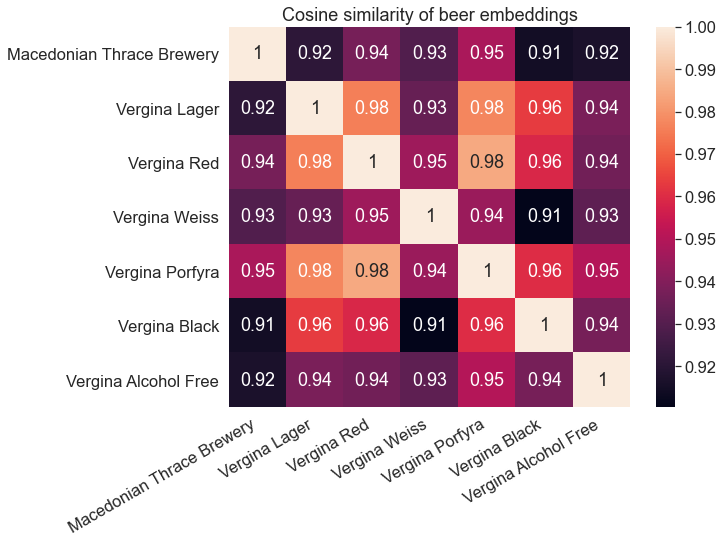

In [55]:
beer_vecs = model.wv['Q12877510', 'Q93552342', 'Q93557205', 'Q93559285', 'Q93558270', 'Q93560567', 'Q97412285']
similarity_mat = [model.wv.cosine_similarities(beer, beer_vecs) for beer in beer_vecs]
mask = np.zeros_like(similarity_mat)
mask[np.triu_indices_from(mask)] = True
labels = ['Macedonian Thrace Brewery', 'Vergina Lager', 'Vergina Red', 'Vergina Weiss', 'Vergina Porfyra', 'Vergina Black', 'Vergina Alcohol Free']
# Could mask to only show the lower triangle, but I think this is actually easier to read without the mask
fig, ax = plt.subplots(figsize=(9,7))
sns.set(font_scale=1.5)
sns.heatmap(similarity_mat, ax=ax, xticklabels=labels, yticklabels=labels, annot=True)
plt.xticks(rotation=30, horizontalalignment='right')
plt.title("Cosine similarity of beer embeddings")
plt.show()